In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# # To make this command work you need to add the folder data_assignment_2 to the root of your Google Drive 
# # Don't forget to upload the actual files there too
# # The best way to do this is the upload the data assignment zip and unzip the files in Google Drive. 
# # It kinda sucks but its one of the few ways to use Google Colab
# # When we turn this in, we might have to directly link to data so it can be run locally 
# %cd /content/drive/MyDrive/data_assignment_2

In [ ]:
# Sanity check 
import os
print(os.listdir())


['TTGT_trades_2019.csv', '.DS_Store', 'TTGT_trades_2020.csv', 'data_assignment.ipynb', 'README.md', '.gitignore', '.gitattributes', 'TTGT_quotes_2020.csv', '.git', '.vscode', 'output.txt', 'TTGT_quotes_2019.csv']


In [ ]:
#Imports and getting data
import pandas as pd
import numpy as np
df_dict = dict()
# os.chdir("/mnt/c/Users/Willie Xia/Desktop/trading2")
for file in os.listdir():
  if file[-4:] == ".csv":
    df_dict[file] = pd.read_csv(file)


In [ ]:
#trim milliseconds/seconds from time
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-10])
    else:
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-13])

In [ ]:
#check work
#print(df_dict["TTGT_quotes_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean().sort_values(by = ['DATE','TIME_M']))

#print(df_dict["TTGT_trades_2019.csv"].sort_values(by = ['DATE','TIME_M']))
#print(df_dict["TTGT_trades_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).agg({'PRICE':'mean','SIZE':'sum'}).sort_values(by = ['DATE','TIME_M']))

Now we will aggregate the tables

In [ ]:
#Average from milliseconds to seconds on quotes
df_dict["TTGT_quotes_2019.csv"] = df_dict["TTGT_quotes_2019.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()
df_dict["TTGT_quotes_2020.csv"] = df_dict["TTGT_quotes_2020.csv"].groupby(['DATE', 'TIME_M'], as_index = False).mean()

#Averaging from seconds to minutes on trades with price as weighted average
def aggregateTrades(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "SIZE"])
    return df.groupby(['DATE','TIME_M'], as_index = False).agg(
        PRICE = ("PRICE", wm),
        SIZE = ("SIZE", "sum")
    )
df_dict["TTGT_trades_2019.csv"] = aggregateTrades(df_dict["TTGT_trades_2019.csv"])
df_dict["TTGT_trades_2020.csv"] = aggregateTrades(df_dict["TTGT_trades_2020.csv"])

In [ ]:
#splitting seconds from time on quotes to create weights
for df in df_dict:
    if 'quotes' in df:
        df_dict[df]['SECONDS'] = df_dict[df]['TIME_M'].apply(lambda x: x[-2:])
        df_dict[df]['TIME_M'] = df_dict[df]['TIME_M'].apply(lambda x: x[:-3])

In [ ]:
#setting up the weights for weighted average
def generateWeights(df):
    weights = []
    currdate = None
    currtime = None
    prevSec = None

    #Simple iteration through each row to calculate row. Accounts for when the day, hour, and minute changes.
    for _, row in df.iterrows():
        date, time, second = row['DATE'], row['TIME_M'], row['SECONDS']
        if date != currdate:
            currdate = date
            currtime = time
            if prevSec != None:
                weights.append(60 - int(prevSec))
            prevSec = second
        else:
            if time != currtime:
                currtime = time
                weights.append(60-int(prevSec))
                prevSec = second
            else:
                weights.append(int(second) - int(prevSec))
                prevSec = second
    weights.append(60-int(prevSec))
    return weights

weights1 = generateWeights(df_dict["TTGT_quotes_2019.csv"])
weights2 = generateWeights(df_dict["TTGT_quotes_2020.csv"])


In [ ]:
#Calculating weighted average

#Weighted average function
def weightedAverage(df):
    wm = lambda x: np.average(x, weights=df.loc[x.index, "WEIGHTS"])
    df = df.groupby(["DATE", "TIME_M"], as_index = False).agg(
        BID = ("BID", wm),
        BIDSIZ = ("BIDSIZ", wm),
        ASK = ("ASK",wm)
    )
    return df

#Setup 2019 and 2020 weights
df_dict["TTGT_quotes_2019.csv"]['WEIGHTS'] = pd.Series(weights1, index=df_dict["TTGT_quotes_2019.csv"].index)
df_dict["TTGT_quotes_2020.csv"]['WEIGHTS'] = pd.Series(weights2, index=df_dict["TTGT_quotes_2020.csv"].index)

#Calculate weighted average
df_dict["TTGT_quotes_2019.csv"] = weightedAverage(df_dict["TTGT_quotes_2019.csv"])
df_dict["TTGT_quotes_2020.csv"] = weightedAverage(df_dict["TTGT_quotes_2020.csv"])


In [ ]:
#sanity check
#print(df_dict["TTGT_quotes_2019.csv"])
#print(df_dict["TTGT_quotes_2020.csv"])
#print(df_dict["TTGT_trades_2019.csv"])
#print(df_dict["TTGT_trades_2020.csv"])
#print(df_dict["TTGT_trades_2020.csv"][["DATE","TIME_M"]])

In [ ]:
#Creating our bid-ask spread data by merging quotes and trades
spread_df_2019 = pd.merge(
    df_dict["TTGT_quotes_2019.csv"], 
    df_dict["TTGT_trades_2019.csv"],
    on=["DATE","TIME_M"],
    how="inner",
)

spread_df_2020 = pd.merge(
    df_dict["TTGT_quotes_2020.csv"], 
    df_dict["TTGT_trades_2020.csv"],
    on=["DATE","TIME_M"],
    how="inner",
)

#Calculating spread
spread_df_2019["SPREAD"] = ((spread_df_2019['ASK'] - spread_df_2019['BID'])/spread_df_2019['PRICE']) * 100
spread_df_2020["SPREAD"] = ((spread_df_2020['ASK'] - spread_df_2020['BID'])/spread_df_2020['PRICE']) * 100

Now that we have our data cleaned and formatted correctly, we can plot the requested graphs.

In [ ]:
#Instantiate plotting
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import cm


In [ ]:
#Function for producing plot
def createPlot(required_data, type):
    #Setting up x, y, and z data
    required_data['TIME_M'] = required_data['TIME_M'].apply(lambda x: int(x.replace(':','')))
    required_data = required_data[required_data['TIME_M'].between(930, 1600)]
    x = pd.to_datetime(required_data['DATE'], format="%Y%m%d").map(datetime.datetime.toordinal)
    y = required_data['TIME_M']
    if type == 0:
        z = required_data['SIZE']
    elif type == 1:
        z = required_data['SPREAD']
    elif type == 2:
        z = required_data['BIDSIZ']

    #Setting up graph nad using plot_trisurf to create colored peaks
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = plt.axes(projection ='3d')
    ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0)
    formattedDateLabel = [str(datetime.datetime.fromordinal(int(x)))[:10] for x in ax.get_xticks().tolist()]
    ax.set_xticklabels(formattedDateLabel)

    #Labeling
    if type == 0:
        ax.set_title('Order Size Graph in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Order Size")
    elif type == 1:
        ax.set_title('Bid-Ask Spread in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Spread")
    elif type == 2:
        ax.set_title('Bid Size in {}'.format(formattedDateLabel[2][:4]))
        ax.set_zlabel("Bid Size")
    ax.set_xlabel("Date")
    ax.set_ylabel("Time in Military")

    fig.show()

/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


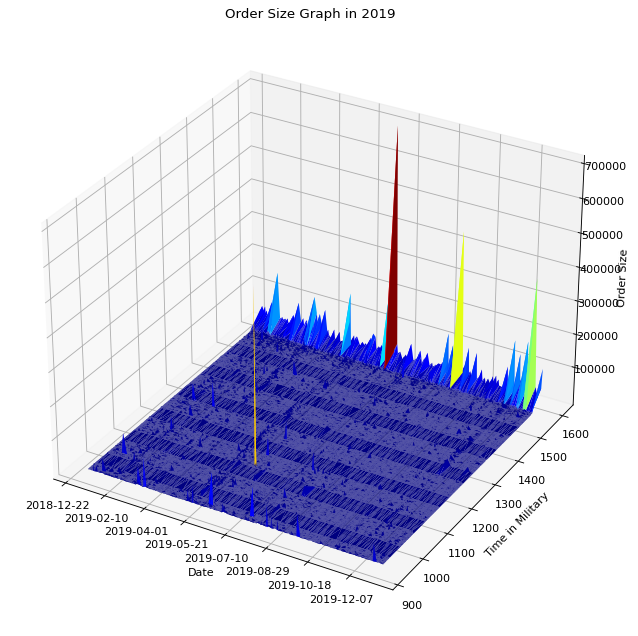

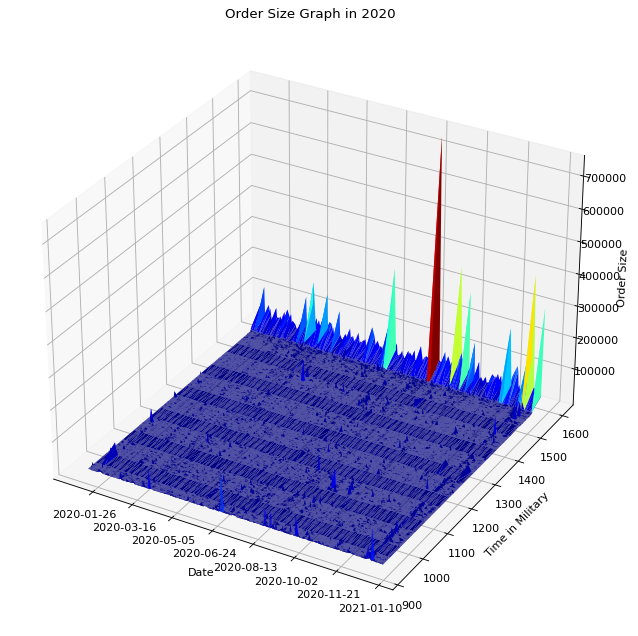

In [ ]:
#PROBLEM 1: Volume Plot
createPlot(df_dict["TTGT_trades_2019.csv"].copy(), 0)
createPlot(df_dict["TTGT_trades_2020.csv"].copy(), 0)


/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


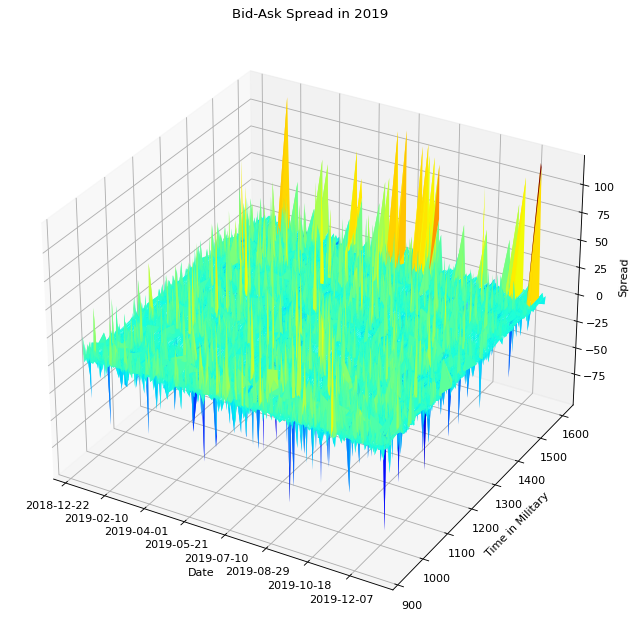

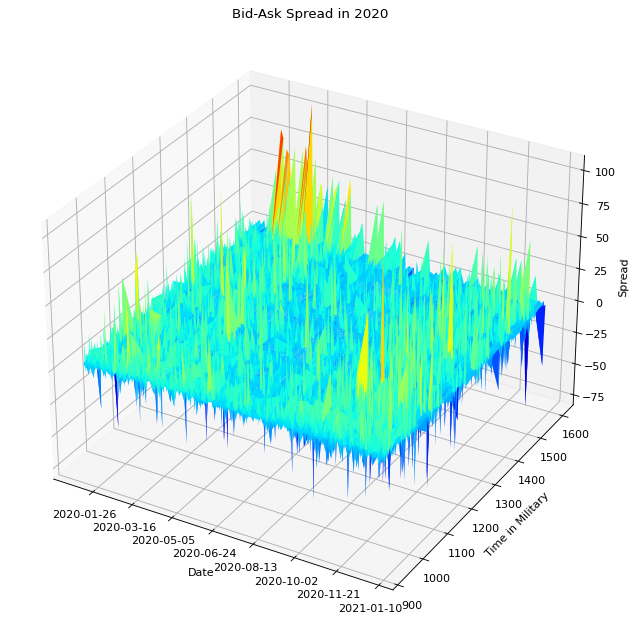

In [ ]:
#PROBLEM 2: Spread
createPlot(spread_df_2019.copy(), 1)
createPlot(spread_df_2020.copy(), 1)


/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(formattedDateLabel)
/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/80863785.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


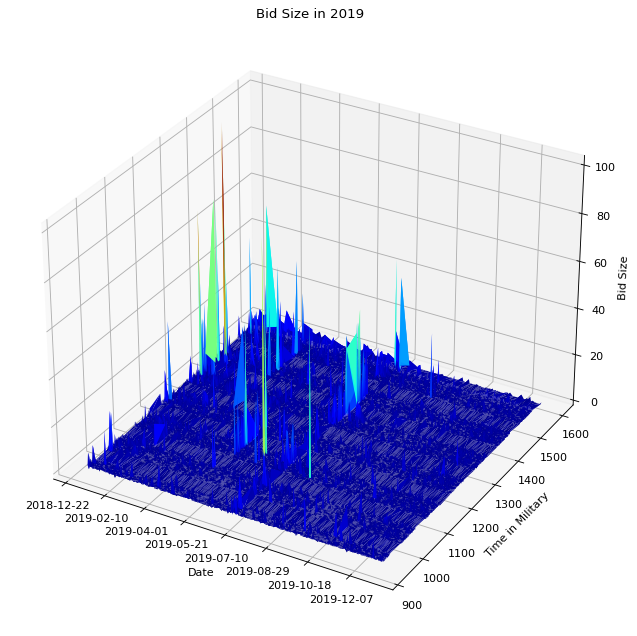

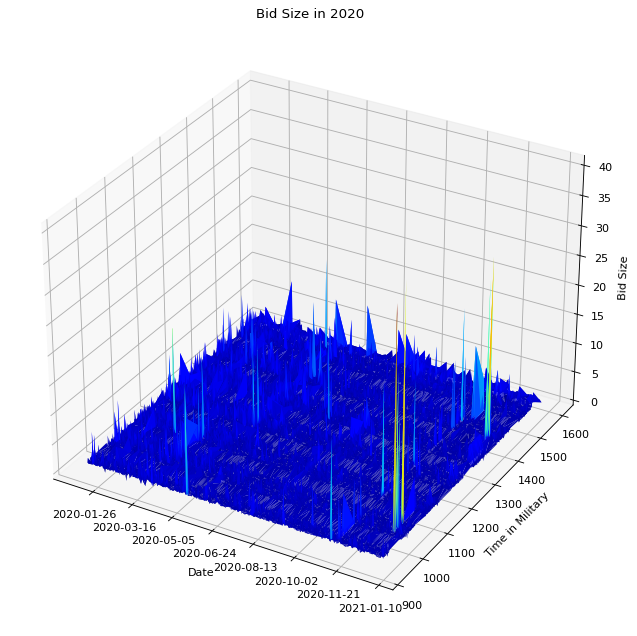

In [ ]:
#PROBLEM 3: Bid Order Size
createPlot(df_dict["TTGT_quotes_2019.csv"].copy(), 2)
createPlot(df_dict["TTGT_quotes_2020.csv"].copy(), 2)

In [ ]:
import random
import datetime

random.seed(2021)

def get_random_times(start_time, end_time):
    """
    Randomize time with a time delta to sell. Sometimes we will not sell anything in a time delta. 
    """
    delta = (end_time - start_time).total_seconds()
    random_delta = random.randrange(0, delta)
    return(start_time + datetime.timedelta(seconds=random_delta))

def time_plus(time, timedelta):
    """
    This is so silly but you can't add timedelta to a time object.
    https://stackoverflow.com/questions/12448592/how-to-add-delta-to-python-datetime-time
    """
    start = datetime.datetime(
        2000, 1, 1,
        hour=time.hour, minute=time.minute, second=time.second)
    end = start + timedelta
    return end.time()

def generate_time_intervals(start_time, end_time, interval_size, start_date, end_date):
    # end_time = time_plus(end_time, interval_size) # Because end time is not inclusive
    start_hour, start_minute, end_hour, end_minute = start_time.hour, start_time.minute, end_time.hour, end_time.minute
    # print(start_hour, start_minute, end_hour, end_minute)
    intervals = []
    temp_time = start_date
    # print(temp_time)
    while temp_time < end_date:
        while not(temp_time.hour == end_hour and temp_time.minute == end_minute):
            intervals.append(temp_time)
            temp_time += interval_size
            # print(temp_time)
        temp_time = temp_time.replace(hour=start_hour, minute=start_minute)
        # print(temp_time)
        temp_time += datetime.timedelta(days=1)

    return(intervals)

In [ ]:
# Implement Random Selling Strategy
# We sample a normal distribution for every opportunity to sell. 
out = ""

start_date = datetime.datetime(2021, 1, 4, 9, 30)
end_date = datetime.datetime(2021, 1, 8, 16, 0)
days_to_sell = (end_date - start_date).days + 1 # Include end date
time_delta = datetime.timedelta(minutes=15)

# Times market opens and closes in our model 
start_time = datetime.time(hour=9, minute=30)
end_time = datetime.time(hour=16, minute=0)

intervals = generate_time_intervals(start_time, end_time, time_delta, start_date, end_date)


num_shares = 1365000 
time_to_sell = len(intervals) # This is the amount of time intervals that we get to sell the stock 
sell_plan = []

round_num = 0 # If set to 0 then we can only buy and sell entire shares. If higher than or equal to 1 then we can buy and sell fractions of shares.


remainding_shares = num_shares
remainding_time = time_to_sell
for i in range(len(intervals)):
    # Dump whatever we have left in the end 
    random_time = get_random_times(intervals[i], intervals[i] + time_delta)
    # print(random_time)
    if i == len(intervals) - 1 and remainding_shares > 0:
        sell_plan.append(remainding_shares)
        remainding_shares -= sell_plan[-1]
        out += str(random_time.strftime("%m/%d/%y;%I:%M%p;")) + "MARKET;" + str(int(sell_plan[-1])) + ";\n"
    else:
        # We also sell randomly. We don't want a consistant stream of selling, easy to get caught if we do so. 
        should_we_sell = np.random.randint(2) # 0 or 1
        if should_we_sell: 
            mu = 2 * remainding_shares / remainding_time # Time two because on average we only sell on half of the time deltas. 
            sigma = mu / 2
            cur_amount_to_sell = round(abs(np.random.normal(mu, sigma)), round_num) # This may not be super matmatically sound...
            if cur_amount_to_sell > remainding_shares:
                cur_amount_to_sell = remainding_shares
        else:
            cur_amount_to_sell = 0
        
        # Adjust the volume and time. Also keep track of the amount we sell
        sell_plan.append(cur_amount_to_sell)
        remainding_shares -= sell_plan[-1]
        remainding_time -= 1
        if cur_amount_to_sell >0:
            out += str(random_time.strftime("%m/%d/%y;%H:%M;")) + "MARKET;" + str(int(sell_plan[-1])) + ";\n"

f = open("output.txt", 'w')
f.write(out)
f.close()




/var/folders/s4/kp5y4dr14d19trtzc9ydqxvm0000gn/T/ipykernel_26132/2213490104.py:11: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  random_delta = random.randrange(0, delta)


In [ ]:
# Sanity check
# print(sum(sell_plan))
# assert(int(sum(sell_plan)) == num_shares)
# print(sell_plan)

1365000.0
[0, 0, 19278.0, 0, 0, 0, 20091.0, 45383.0, 0, 18247.0, 29504.0, 0, 0, 0, 30671.0, 24815.0, 0, 0, 0, 46732.0, 0, 24618.0, 0, 0, 0, 0, 27340.0, 45824.0, 40035.0, 0, 18050.0, 52666.0, 22513.0, 55954.0, 15483.0, 0, 0, 0, 0, 0, 41124.0, 0, 33624.0, 26772.0, 24028.0, 0, 0, 21428.0, 0, 4590.0, 0, 31324.0, 36135.0, 0, 0, 10633.0, 23672.0, 18392.0, 0, 0, 0, 0, 46785.0, 0, 26916.0, 0, 0, 0, 0, 40357.0, 37046.0, 44865.0, 11339.0, 30344.0, 28527.0, 39282.0, 21209.0, 6861.0, 21185.0, 33891.0, 15110.0, 0, 6613.0, 0, 31462.0, 17237.0, 22392.0, 0, 0, 0, 14757.0, 16083.0, 13510.0, 0, 6178.0, 0, 7965.0, 4614.0, 0, 11546.0]
